In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pywt 
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import *
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix
import gc
import os
lsdir = "../input"
print(os.listdir(lsdir))

Using TensorFlow backend.


['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [2]:
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler,LabelEncoder
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
from sklearn.feature_selection import SelectKBest,chi2
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut,RandomizedSearchCV,GroupKFold,KFold


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1081363552518782901
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13297164628987766414
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15542220572722395195
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15856359834
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12778182626877479673
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
Xtrain = pd.read_csv(lsdir+'/X_train.csv')
Ytrain = pd.read_csv(lsdir+'/y_train.csv')
Xtest = pd.read_csv(lsdir+'/X_test.csv')
submission = pd.read_csv(lsdir+'/sample_submission.csv')

In [5]:
Ytrain['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [6]:
# this part credit to https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73
data = Xtrain.copy()
test = Xtest.copy()

def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)
    return X, Y, Z


def fe_step0 (actual):
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    return actual

def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

data = fe_step0(data)
test = fe_step0(test)
data = fe_step1(data)
test = fe_step1(test)
print (data.shape)
data.head()

(487680, 22)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


In [7]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
   
    groupeddata = data.groupby('series_id').agg(lambda x: x.tolist()).reset_index()
    groupeddata.drop(['series_id','row_id','measurement_number'],axis=1,inplace=True)
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def der_and_intgeral(row,col,s):
        x=row[col]
        l=len(x)
        intgeral = [np.mean(x[max(0,i-s):min(l,i+s)]) for i in range(l)]
        detail = np.array(x)- np.array(intgeral)
        detail = detail[s:l-s]
        return detail
    
    for col in groupeddata.columns:
        groupeddata[col+'_detl'] = groupeddata.apply(der_and_intgeral,col=col,s=5,axis=1)
    groupeddata.head()    
    
    for col in groupeddata.columns:
        df[col + '_mean'] = [np.mean(x) for x in groupeddata[col]]
        df[col + '_median'] = [np.median(x) for x in groupeddata[col]]
        df[col + '_max'] = [np.max(x) for x in groupeddata[col]]
        df[col + '_min'] = [np.min(x) for x in groupeddata[col]]
        df[col + '_std'] = [np.std(x) for x in groupeddata[col]]
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = [np.mean(np.abs(np.diff(x))) for x in groupeddata[col]]
        df[col + '_mean_change_of_abs_change'] = [mean_change_of_abs_change(x) for x in groupeddata[col]]
        df[col + '_abs_max'] = [np.max(np.abs(x)) for x in groupeddata[col]]
        df[col + '_abs_min'] = [np.min(np.abs(x)) for x in groupeddata[col]]
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2

    
    return df

In [8]:
%%time
data = feat_eng(data)
test = feat_eng(test)
print ("New features: ",data.shape)

New features:  (3810, 552)
CPU times: user 4min 58s, sys: 1.08 s, total: 4min 59s
Wall time: 4min 59s


In [9]:
data.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_mean_change_of_abs_change,orientation_Z_abs_max,orientation_Z_abs_min,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,...,totl_anglr_vel_detl_mean_change_of_abs_change,totl_anglr_vel_detl_abs_max,totl_anglr_vel_detl_abs_min,totl_anglr_vel_detl_abs_avg,totl_linr_acc_detl_mean,totl_linr_acc_detl_median,totl_linr_acc_detl_max,totl_linr_acc_detl_min,totl_linr_acc_detl_std,totl_linr_acc_detl_range,totl_linr_acc_detl_maxtoMin,totl_linr_acc_detl_mean_abs_chg,totl_linr_acc_detl_mean_change_of_abs_change,totl_linr_acc_detl_abs_max,totl_linr_acc_detl_abs_min,totl_linr_acc_detl_abs_avg,totl_xyz_detl_mean,totl_xyz_detl_median,totl_xyz_detl_max,totl_xyz_detl_min,totl_xyz_detl_std,totl_xyz_detl_range,totl_xyz_detl_maxtoMin,totl_xyz_detl_mean_abs_chg,totl_xyz_detl_mean_change_of_abs_change,totl_xyz_detl_abs_max,totl_xyz_detl_abs_min,totl_xyz_detl_abs_avg,acc_vs_vel_detl_mean,acc_vs_vel_detl_median,acc_vs_vel_detl_max,acc_vs_vel_detl_min,acc_vs_vel_detl_std,acc_vs_vel_detl_range,acc_vs_vel_detl_maxtoMin,acc_vs_vel_detl_mean_abs_chg,acc_vs_vel_detl_mean_change_of_abs_change,acc_vs_vel_detl_abs_max,acc_vs_vel_detl_abs_min,acc_vs_vel_detl_abs_avg
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000361,0.00131,0.998275,0.000015,2.380952e-07,0.75953,0.75822,0.758875,-0.634008,-0.634270,-0.63306,-0.63456,0.000469,0.00150,0.997636,0.000018,0.000000e+00,0.63456,0.63306,0.633810,-0.105474,-0.105500,-0.104610,-0.106140,0.000430,0.001530,0.985585,0.000051,7.936508e-08,0.106140,0.104610,0.105375,-0.106470,-0.106555,-0.105590,-0.107050,...,-0.000189,0.089413,0.000199,0.044806,0.017286,0.032247,3.124181,-2.810785,0.946195,5.934966,-1.111498,0.710701,0.007190,3.124181,0.003397,1.563789,-2.270323e-07,-3.213617e-07,0.000019,-0.000019,0.000006,0.000038,-0.987316,0.000006,3.747708e-08,0.000019,5.153450e-08,0.000010,-4.495773,-25.312025,479.786318,-196.745570,115.155059,676.531889,-2.438613,107.869655,-0.222255,479.786318,0.452068,240.119193
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.958665,0.241867,0.241890,0.24270,0.24074,0.000497,0.00196,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.241720,0.031650,0.031688,0.032341,0.030504,0.000506,0.001837,1.060222,0.000048,3.253968e-07,0.032341,0.030504,0.031423,-0.146876,-0.146910,-0.145870,-0.148090,...,-0.000458,0.107049,0.000062,0.053556,0.028621,-0.104183,6.397751,-4.706496,1.861889,11.104248,-1.359345,1.420263,0.025441,6.397751,0.017310,3.207531,6.494643e-07,6.340432e-07,0.000051,-0.000069,0.000021,0.000120,-0.745742,0.000016,6.799247e-08,0.000069,3.479063e-07,0.000035,-0.955977,-17.375697,417.923722,-116.394950,81.139106,534.318672,-3.590566,61.529058,0.105054,417.923722,0.070161,208.996942
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001372,0.00490,0.990473,0.000041,0.000000e+00,0.51434,0.50944,0.511890,-0.846171,-0.846210,-0.84490,-0.84779,0.000782,0.00289,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,0.846345,-0.129371,-0.129405,-0.128520,-0.130300,0.000538,0.001780,0.986339,0.000059,-1.746032e-06,0.130300,0.128520,0.129410,-0.071082,-0.071139,-0.070378,-0.071535,...,-0.000308,0.059711,0.000539,0.030125,-0.033973,-0.007395,2.005583,-2.091225,0.811464,4.096807,-0.959047,0.671876,-0.002439,2.091225,0.0

In [10]:
data.fillna(0,inplace=True)
test.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [11]:
target  = Ytrain.copy()
onehot = pd.get_dummies(target['surface'])
y_train_labels = onehot.columns
target['surface'] = np.argmax(onehot.values,axis=1)

In [12]:
target.head(10)

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6
5,5,1,7
6,6,34,5
7,7,31,1
8,8,33,4
9,9,11,7


In [13]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0

Fold: 0 score: 0.9168831168831169
Fold: 1 score: 0.8802083333333334
Fold: 2 score: 0.9138381201044387
Fold: 3 score: 0.900523560209424
Fold: 4 score: 0.910761154855643
Fold: 5 score: 0.89501312335958
Fold: 6 score: 0.8661417322834646
Fold: 7 score: 0.9102902374670184
Fold: 8 score: 0.9047619047619048
Fold: 9 score: 0.9281914893617021


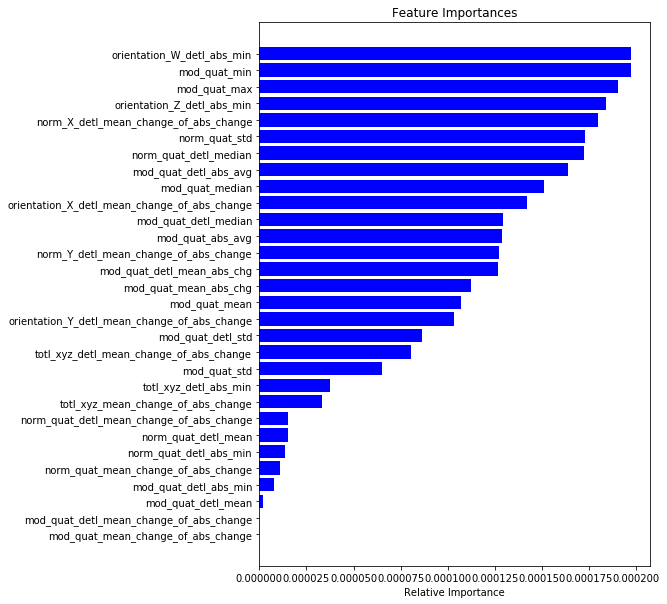

In [14]:
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = data.columns
    
    if model.score(data.iloc[val_idx],target['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()

In [15]:
print('Avg Accuracy RF', score / folds.n_splits)

Avg Accuracy RF 0.9026612772619625


In [16]:
matrix = confusion_matrix(measured,target['surface'])
print(matrix)

[[159   5   0   0   3   3   1   3   0]
 [ 14 707  11   0  16  15   7  18  14]
 [  0   3 309   0   6   2   0   1   4]
 [  0   0   0  13   0   0   0   0   0]
 [  0   8   0   0 274   5   0   3   1]
 [  4  15   5   0   1 688   2   7  21]
 [  2  11   3   2   1   5 280   6   4]
 [  1   5   5   0   0   3   0 468  22]
 [  9  25  30   6   7  11   7   8 541]]


In [17]:
def confidence(matrix):
    cof = []
    for i,row in enumerate(matrix):
        cof.append(row[i]/sum(row))
    return np.array(cof)

In [18]:
cof1 = confidence(matrix)
print(cof1)

[0.9137931  0.88154613 0.95076923 1.         0.94158076 0.92597577
 0.89171975 0.92857143 0.84006211]


In [19]:
predicted[10:]

array([[3.800e-03, 6.840e-02, 1.664e-01, ..., 6.200e-03, 6.000e-04,
        2.584e-01],
       [3.220e-02, 1.996e-01, 5.180e-02, ..., 1.860e-02, 2.548e-01,
        1.012e-01],
       [1.320e-02, 4.140e-02, 6.260e-02, ..., 9.000e-03, 9.400e-03,
        6.582e-01],
       ...,
       [3.400e-03, 3.820e-01, 6.820e-02, ..., 2.800e-03, 5.000e-02,
        1.440e-02],
       [2.210e-01, 4.558e-01, 2.400e-03, ..., 6.000e-04, 2.200e-02,
        2.892e-01],
       [4.320e-02, 2.780e-02, 3.180e-02, ..., 2.120e-02, 4.000e-03,
        7.922e-01]])

In [20]:
# i=1
# kk=7
# s = 5
# plt.figure(figsize=[10,30])

# for col in groupedX.columns:
#     data = groupedX.loc[kk][col]
#     l=len(data)
#     plt.subplot(10,3,i)
#     plt.plot(data)
#     plt.title(col)
#     i+=1
#     plt.subplot(10,3,i)
#     intgeral=[np.mean(data[max(0,i-s):min(l,i+s)]) for i in range(l)]
#     print(len(intgeral[s:l-s]))
#     detail=np.array(data)- np.array(intgeral)
#     plt.plot(intgeral[s:l-s])
#     plt.plot(data[s:l-s])
#     i+=1
#     plt.subplot(10,3,i)
#     plt.plot(detail[s:l-s])
#     i+=1


In [21]:
# colourmap=dict(zip(list(Ytrain['surface'].unique()),['r','orange','y','g','b','purple','k','grey','pink']))
# surfacedict=dict(zip(list(Ytrain['surface'].unique()),range(1,11)))
# s=5
# for col in groupedX.columns:
#     plt.figure(figsize=[36,4])
#     plt.title(col)
#     for i in range(100):
#         data = groupedX.loc[i][col]
#         intgeral=[np.mean(data[max(0,i-s):min(l,i+s)]) for i in range(l)]
#         detail= np.array(data)- np.array(intgeral)
#         plt.subplot(1,9,surfacedict[Ytrain.loc[i]['surface']])
#         plt.plot(detail,color=colourmap[Ytrain.loc[i]['surface']],label=Ytrain.loc[i]['surface'])
    #plt.legend()

In [22]:
def der_and_intgeral(data,s_list):
    l=len(data)
    details=[]
    for s in s_list:
        intgeral = [np.mean(data[max(0,i-s):min(l,i+s)]) for i in range(l)]
        detail = np.array(data)- np.array(intgeral)
        detail -= np.mean(detail[s:l-s])
        detail = list(detail[s:l-s])
        details += detail
    return np.array(details)

In [23]:
def multi_level(data,s,level):
    details=[]
    for i in range(level):
        l=len(data)
        intgeral = [np.mean(data[max(0,i-s):min(l,i+s)]) for i in range(l)]
        detail = np.array(data)- np.array(intgeral)
        detail -= np.mean(detail[s:l-s])
        detail = list(detail[s:l-s])
        details += detail
        data = detail
    return np.array(details)
        

In [24]:
def normalization(x_train):
    for i in range(x_train.shape[-1]):
        maxspan = 0
        for x in x_train:
            maxspan= max(maxspan,np.max(x[:,i])-np.min(x[:,i]))
        x_train[:,:,i]/= maxspan
    return x_train

In [25]:
def data_prepare(Xtrain,s_list):
    Xtrain['totl_anglr_vel'] = (Xtrain['angular_velocity_X']**2 + Xtrain['angular_velocity_Y']**2 + Xtrain['angular_velocity_Z']**2)** 0.5
    Xtrain['totl_linr_acc'] = (Xtrain['linear_acceleration_X']**2 + Xtrain['linear_acceleration_Y']**2 + Xtrain['linear_acceleration_Z']**2)**0.5
    Xtrain['totl_xyz'] = (Xtrain['orientation_X']**2 + Xtrain['orientation_Y']**2 + Xtrain['orientation_Z']**2)**0.5
    Xtrain['acc_vs_vel'] = Xtrain['totl_linr_acc'] / Xtrain['totl_anglr_vel']
    groupedX = Xtrain.groupby('series_id').agg(lambda x: x.tolist()).reset_index()
    groupedX.drop(['series_id','row_id','measurement_number'],axis=1,inplace=True)
    Xrows,Xcols = groupedX.shape
    columns = groupedX.columns
    detail = der_and_intgeral(groupedX.loc[0][columns[0]],s_list)
    #detail = multi_level(groupedX.loc[0][columns[0]],5,2)
    length = len(detail)
    x_train = np.ndarray(shape=(Xrows, length, Xcols)).astype('float32')
    for ii in tqdm(range(Xrows)):
        for jj,col in enumerate(columns):
            signal = groupedX.loc[ii][col]
            detail = der_and_intgeral(signal,s_list)#multi_level(signal,5,2)#
            x_train[ii, :, jj] = detail
    for i in range(x_train.shape[-1]):
        maxspan = 0
        for x in x_train:
            maxspan= max(maxspan,np.max(x[:,i])-np.min(x[:,i]))
            #maxspan= max(maxspan,np.percentile(x[:,i],95)-np.percentile(x[:,i],5))
        x_train[:,:,i]/= maxspan
    return x_train

In [26]:
s_list=[5]
x_train = data_prepare(Xtrain,s_list)

In [27]:
onehot = pd.get_dummies(Ytrain['surface'])
y_train_labels = onehot.columns
y_train = onehot.values
print(y_train_labels)
print(x_train.shape,y_train.shape)

Index(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled', 'wood'],
      dtype='object')
(3810, 118, 14) (3810, 9)


In [28]:
def model_cnn(input_shape):
    model_m = Sequential()
    model_m.add(Conv1D(64, 3, activation='relu', input_shape=(input_shape[1],input_shape[2])))
    #model_m.add(MaxPooling1D(3))
    model_m.add(Conv1D(128, 3, activation='relu'))
    model_m.add(MaxPooling1D(3))
    #model_m.add(Conv1D(128, 5, activation='relu'))
    model_m.add(GlobalAveragePooling1D())#model_m.add(Flatten())#
    model_m.add(Dropout(0.5))
    model_m.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_m.add(Dense(num_classes, activation='softmax'))
    model_m.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    return model_m

In [29]:
def history_plot(history):
    plt.figure(figsize=[15,7])
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [30]:
num_classes = 9
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=2019).split(x_train, np.zeros(shape=(x_train.shape[0], 1))))
preds_val = []
y_val = []
cal_list=[]

Beginning fold 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


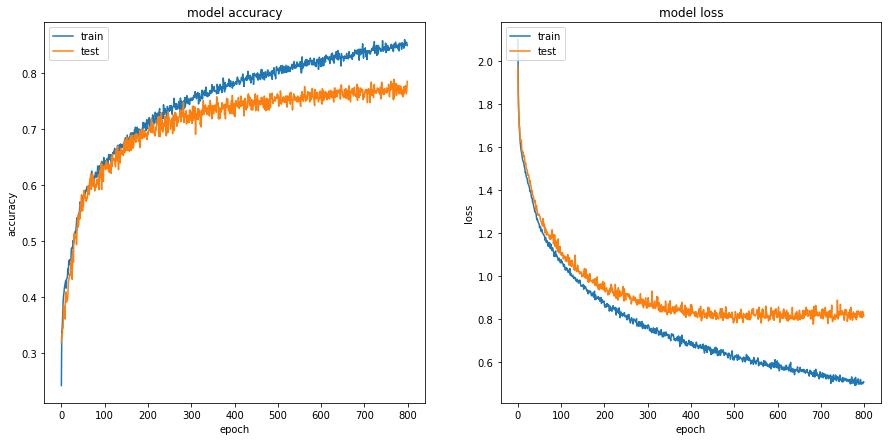

Beginning fold 2


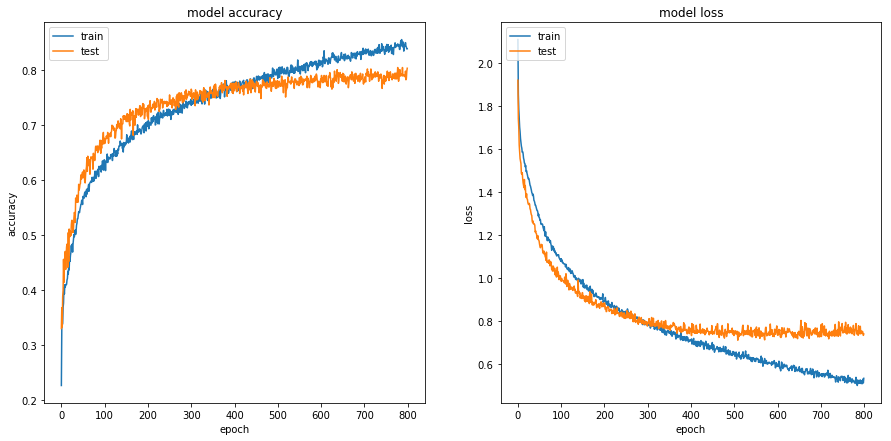

Beginning fold 3


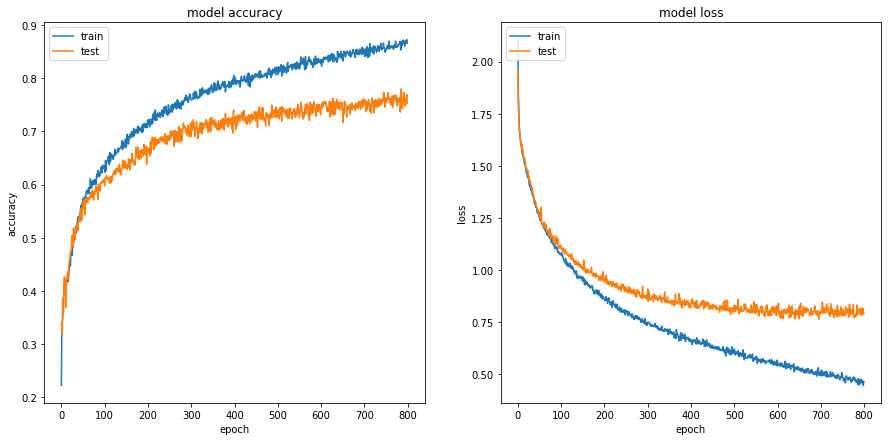

Beginning fold 4


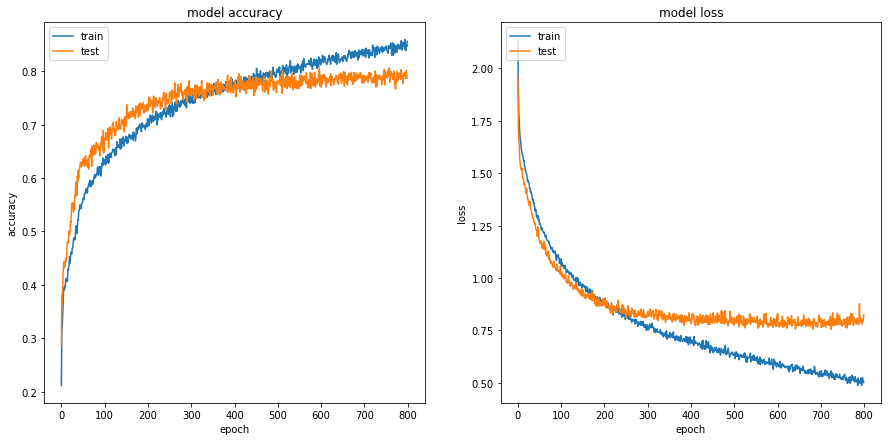

Beginning fold 5


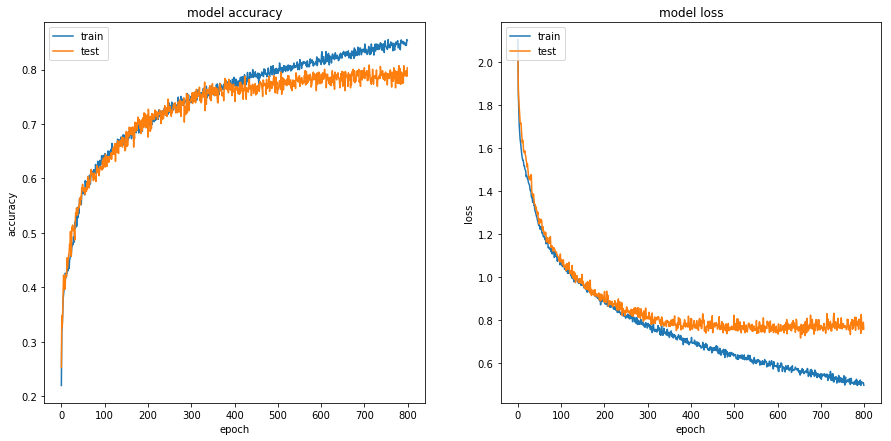

(3810, 9) (3810, 9)


In [31]:
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() 
    print("Beginning fold {}".format(idx+1))
    cal_list.append(val_idx)
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]
    # instantiate the model for this fold
    model = model_cnn(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=0, monitor='val_acc', mode='max')
    # Train, train, train
    history = model.fit(train_X, train_y, batch_size=32, epochs=800, validation_data=[val_X, val_y], verbose=0, callbacks=[ckpt])
    history_plot(history)
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=256))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)
y_val = np.concatenate(y_val)
cal_list=np.concatenate(cal_list)
print(preds_val.shape, y_val.shape)

In [32]:
K.clear_session()
gc.collect()

54383

In [33]:
wrongpred = []
preds_val = np.argmax(preds_val, axis=1)
y_val = np.argmax(y_val, axis=1)
for i,y in enumerate(y_val):
    if preds_val[i]!= y:
        #print(cal_list[i],y_train_labels[preds_val[i]],y_train_labels[y])
        wrongpred.append(cal_list[i])
print(wrongpred)
print(1-len(wrongpred)/len(y_val))

[13, 20, 63, 81, 110, 111, 161, 177, 181, 189, 201, 213, 239, 254, 255, 271, 285, 324, 350, 359, 389, 415, 417, 462, 490, 526, 538, 619, 658, 666, 723, 726, 734, 747, 753, 761, 796, 798, 814, 816, 836, 843, 896, 962, 969, 1010, 1024, 1044, 1052, 1077, 1083, 1107, 1117, 1129, 1178, 1180, 1205, 1293, 1297, 1321, 1329, 1360, 1363, 1382, 1395, 1397, 1411, 1429, 1438, 1441, 1469, 1482, 1505, 1508, 1539, 1556, 1562, 1580, 1587, 1598, 1614, 1654, 1656, 1684, 1730, 1763, 1768, 1797, 1856, 1861, 1885, 1893, 1922, 1923, 1927, 1964, 1973, 1978, 1999, 2013, 2024, 2037, 2074, 2084, 2126, 2234, 2304, 2333, 2346, 2354, 2384, 2422, 2435, 2438, 2485, 2620, 2676, 2709, 2744, 2756, 2762, 2808, 2832, 2834, 2846, 2886, 3015, 3027, 3068, 3118, 3150, 3158, 3186, 3211, 3242, 3245, 3268, 3276, 3282, 3311, 3346, 3367, 3443, 3449, 3465, 3474, 3493, 3509, 3510, 3512, 3517, 3521, 3527, 3559, 3604, 3661, 3687, 3763, 3770, 3795, 3807, 27, 41, 58, 76, 93, 100, 120, 174, 204, 222, 268, 399, 442, 491, 517, 532, 591, 63

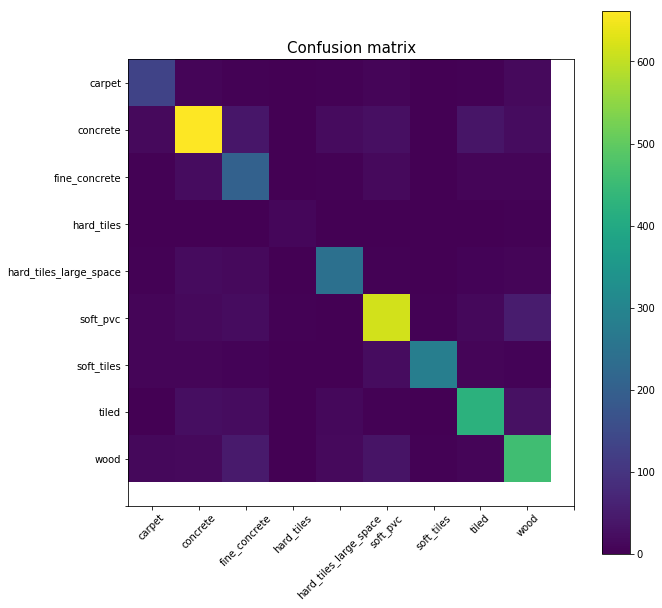

In [34]:
confused = confusion_matrix(preds_val,y_val)
plt.figure(figsize=(10, 10))
plt.imshow(confused,interpolation='nearest')
plt.colorbar()
plt.title('Confusion matrix', size=15)
plt.xticks(range(10), y_train_labels, rotation=45)
plt.yticks(range(10), y_train_labels)
plt.show()

In [35]:
cof2 = confidence(confused)
print(cof2)

[0.74157303 0.80145278 0.75091575 0.70588235 0.80528053 0.83355886
 0.81556196 0.81765835 0.75577558]


In [36]:
X_test = data_prepare(Xtest,s_list)

In [37]:
X_test.shape

(3816, 118, 14)

In [38]:
preds_test = []
model = model_cnn(X_test.shape)
for i in range(5):
    model.load_weights('weights_{}.h5'.format(i))
    pred = model.predict(X_test, batch_size=300, verbose=1)
    print(pred.shape)
    preds_test.append(pred)
print(np.asarray(preds_test).shape)

3816/3816 [==============================] - 0s 51us/step
(3816, 9)
3816/3816 [==============================] - 0s 9us/step
(3816, 9)
3816/3816 [==============================] - 0s 9us/step
(3816, 9)
3816/3816 [==============================] - 0s 9us/step
(3816, 9)
3816/3816 [==============================] - 0s 9us/step
(3816, 9)
(5, 3816, 9)


In [39]:
preds_test = np.mean(preds_test, axis=0)
#preds_test = cof1*np.array(predicted)+ cof2*np.array(preds_test)
preds_test = 0.7*np.array(predicted)+ 0.3*np.array(preds_test)
preds_test = np.argmax(preds_test,axis=1)
preds_test.shape

(3816,)

In [40]:
preds_test = [y_train_labels[i] for i in preds_test]
print(preds_test[:10])

['hard_tiles_large_space', 'carpet', 'tiled', 'carpet', 'soft_tiles', 'concrete', 'concrete', 'concrete', 'wood', 'wood']


In [41]:
submission['surface'] = preds_test
submission.to_csv('submission.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [42]:
submission['surface'].value_counts()

concrete                  897
wood                      739
soft_pvc                  715
soft_tiles                424
tiled                     345
hard_tiles_large_space    327
fine_concrete             239
carpet                    128
hard_tiles                  2
Name: surface, dtype: int64

In [43]:
Ytrain['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [44]:
#0.95,0.67
# verbose, epochs, batch_size = True, 1000, 32
# model_m = Sequential()
# model_m.add(Conv1D(32, 3, activation='relu', input_shape=(length, n_signals)))
# model_m.add(Conv1D(64, 3, activation='relu'))
# model_m.add(MaxPooling1D(3))
# model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
# model_m.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# model_m.add(Dense(num_classes, activation='softmax'))

In [45]:
#0.9,0.73
# verbose, epochs, batch_size = True, 500, 32
# # define model
# model_m = Sequential()
# model_m.add(Conv1D(64, 3, activation='relu', input_shape=(length, n_signals)))
# #model_m.add(MaxPooling1D(3))
# model_m.add(Conv1D(128, 3, activation='relu'))
# model_m.add(MaxPooling1D(3))
# #model_m.add(Conv1D(128, 3, activation='relu'))
# #model_m.add(Conv1D(64, 5, activation='relu'))
# model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
# model_m.add(Dense(64, activation='relu'))#,kernel_regularizer=regularizers.l2(0.001)))
# model_m.add(Dense(num_classes, activation='softmax'))
# print(model_m.summary())

In [46]:
#0.88 0.76
# verbose, epochs, batch_size = True, 1000, 16
# model_m = Sequential()
# model_m.add(Conv1D(64, 3, activation='relu', input_shape=(length, n_signals)))
# model_m.add(Conv1D(128, 3, activation='relu'))
# model_m.add(MaxPooling1D(3))
# model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
# model_m.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# model_m.add(Dense(num_classes, activation='softmax'))
# print(model_m.summary())

In [47]:
# 1.12 0.79  /1.13 0.81
# verbose, epochs, batch_size = True, 500, 16
# # define model
# model_m = Sequential()
# model_m.add(Conv1D(64, 3, activation='relu', input_shape=(length, n_signals)))
# model_m.add(Conv1D(128, 3, activation='relu'))
# model_m.add(MaxPooling1D(3))
# model_m.add(Flatten())#model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
# model_m.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# model_m.add(Dense(num_classes, activation='softmax'))